In [ ]:
import torch, torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
import tqdm
import matplotlib.pyplot as plt

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [23]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.to(device)
freeze_layers = True

In [ ]:
if freeze_layers:
    for param in resnet.parameters():
        param.requires_grad = False
    for param in resnet.fc.parameters():
        param.requires_grad = True

In [4]:
augmentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(10),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

default = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(10),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)


In [6]:
cifar_train = torchvision.datasets.CIFAR10("CIFAR_train", train=True, download=True, transform=augmentation)
cifar_test = torchvision.datasets.CIFAR10("CIFAR_test", train=False, download=True, transform=default)

100%|██████████| 170498071/170498071 [00:07<00:00, 21428964.57it/s]


Extracting CIFAR_train/cifar-10-python.tar.gz to CIFAR_train


100%|██████████| 170498071/170498071 [00:07<00:00, 22507371.22it/s]


Extracting CIFAR_test/cifar-10-python.tar.gz to CIFAR_test


In [12]:
trainloader = torch.utils.data.DataLoader(cifar_train,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=1)
testloader = torch.utils.data.DataLoader(cifar_test,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=1)    

In [31]:
optimizer = torch.optim.Adam(resnet.parameters())
crit = torch.nn.CrossEntropyLoss()
train_losses = []
val_losses = []

for epoch in range(1):
  tq = tqdm.tqdm(trainloader)
  
  train_loss_sum = 0
  train_loss_n = 0
  # val
  if epoch % 5 == 0:
    for (data,gt) in testloader:
      data = data.to(device)
      gt = gt.to(device)
      pred = resnet(data)
      loss = crit(pred,gt)
      val_losses.append(loss.item())
      break   
  for (data, gt) in tq:
    data = data.to(device)
    gt = gt.to(device)
    with torch.enable_grad():
      pred = resnet(data)
      loss = crit(pred, gt)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss_sum += loss
      train_loss_n += 1
  train_loss_avg = train_loss_sum / train_loss_n
  train_losses.append(train_loss_avg.item())
  tq.set_description(f"epoch loss: {train_loss_avg}")

  0%|          | 0/6250 [00:04<?, ?it/s]


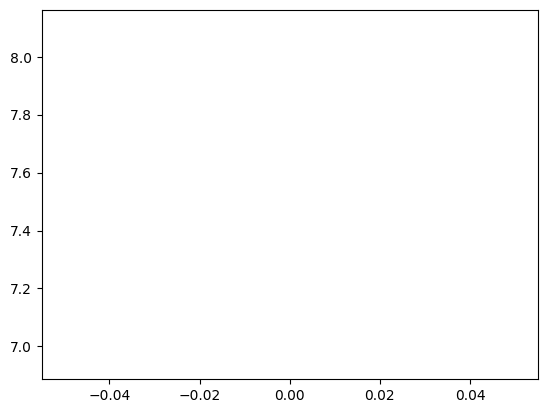

In [34]:
plt.plot(train_losses)
plt.plot(val_losses)